In [1]:
tommy_error_dataset = "/storage2/projects/smartEM/em-vis/smartem-data-train-errors.hdf5"
shashata_error_dataset = "/storage2/projects/smartEM/errnet-data/smartem-data-error-noEM-train.hdf5"

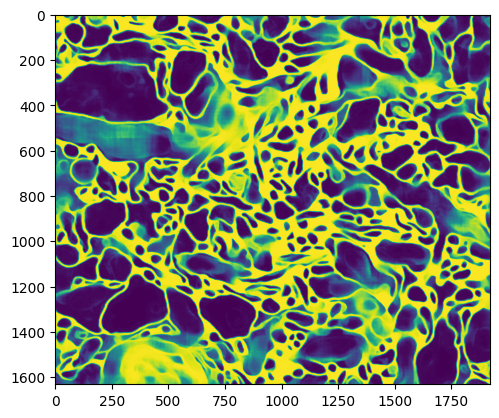

In [3]:
import matplotlib.pyplot as plt
plt.imshow(im_shashata)

(1632, 1920) uint8
(1632, 1920) uint8


In [7]:
# open both files and compare contents
import h5py
import numpy as np

tommy = h5py.File(tommy_error_dataset, 'r')
shashata = h5py.File(shashata_error_dataset, 'r')

# check if the datasets are the same
for key in tommy.keys():
    if key in shashata.keys():
        print(key)
        im_tommy = tommy[key]['50']['im'][:]
        im_shashata = shashata[key]['50']['im'][:]
        # tommy_data = tommy[key][:]
        # shashata_data = shashata[key][:]
        print(np.allclose(im_tommy, im_shashata))
    else:
        print(f"Key {key} not found in shashata")

001_1_1
False
001_1_2
False
001_2_1
True
001_2_2
False
002_1_1
False
002_1_2
True
002_2_1
False
002_2_2
False
003_1_1
False
003_2_1
False
003_2_2
False
004_1_1
False
004_1_2
True
004_2_1
False
004_2_2
False
005_1_1
True
005_1_2
True
005_2_1
True
005_2_2
False
006_1_1
False
006_1_2
True
006_2_2
True
007_1_1
False
007_1_2
True
007_2_1
False
007_2_2
True
008_1_1
True
008_2_1
True
008_2_2
False
009_1_1
False
009_1_2
False
009_2_1
False
009_2_2
True
010_1_1
True
010_1_2
True
010_2_1
False
010_2_2
True
011_1_1
True
011_1_2
True
011_2_1
True
011_2_2
True
012_1_1
True
012_1_2
True
012_2_1
False
012_2_2
False
013_1_1
True
013_1_2
False
013_2_2
False
014_1_2
True
014_2_1
False
014_2_2
True
015_1_2
True
015_2_1
True
016_1_1
True
016_1_2
True
016_2_1
True
016_2_2
False
017_1_1
True
017_1_2
False
017_2_1
False
017_2_2
True
018_1_1
True
018_2_2
True
019_1_1
False
019_1_2
False
019_2_1
False
019_2_2
False
020_1_1
False
020_1_2
True
020_2_1
False
020_2_2
False
021_1_1
True
021_1_2
False
021_2_1
True
0

(1632, 1920) uint8
(1632, 1920) uint8


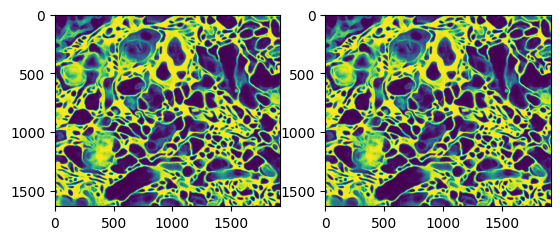

In [10]:
im_tommy = tommy["001_1_1"]['50']['im'][:]
im_shashata = shashata["001_1_1"]['50']['im'][:]
print(im_tommy.shape, im_tommy.dtype)
print(im_shashata.shape, im_shashata.dtype)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(im_tommy)
ax[1].imshow(im_shashata)

In [1]:
from smartem.offline.train_mb_error_detector.NNtools import UNet
from smartem.segmentation import segmenter
from tools import get_error_map, get_error_GT
import torch
import h5py
from tqdm import tqdm
import numpy as np


model_weights = "/home/ssawmya-local/FM_work/smartem_support/fusedem2mb_segformer/unet_50_1.29e-01.pth"
in_dataset_h5 = "/storage2/projects/smartEM/em-vis/smartem-data-train.hdf5"
out_dataset_h5 = "/storage2/projects/smartEM/errnet-data/smartem-data-error-em-train.hdf5"
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

# Make segmenter object which will perform prediction
net = UNet.UNet(n_channels=1,n_classes=2)
Iseg = segmenter.Segmenter(model_weights, device=device)
Iseg.set_model(model_class=net)

base_dwt = 50

# Make predictions and compute errors
emaps = []
idx = 0

In [2]:
with h5py.File(in_dataset_h5, 'r') as h5:

    regs=h5.attrs["regs"]
    data_to_save = {}
    out_regs = []
    uncertainty_masks = []
    emaps = []
    mb_probs_list = []
    slowest_dwt = 1200
    idx = 0
    for reg in tqdm(regs, desc="generating membrane predictions..."):
        
        hdt_im = h5[reg+"/"+str(slowest_dwt)+"/im"]
        _, hdt_mb_probs = Iseg.get_membranes(hdt_im, get_probs=True)
        hdt_mb_probs = (hdt_mb_probs*255).astype(np.uint8)

        im = h5[reg+"/"+str(base_dwt)+"/im"]
        im = im[:]
        _, mb_probs = Iseg.get_membranes(im, get_probs=True)
        uncertainty_mask = np.zeros_like(mb_probs)

        # mark all prediction between 0.4 and 0.6 as uncertain
        uncertainty_mask[(mb_probs>0.45) & (mb_probs<0.5)] = 1
        uncertainty_masks.append(uncertainty_mask)
        mb_probs_list.append(mb_probs)
    
        emap = get_error_GT(mb_probs, hdt_mb_probs)
        emap = (emap*255).astype(np.uint8)

        emaps.append(emap)

        idx += 1
        if idx == 20:
            break

        # print(len(np.unique(mb_probs)))
        # mask = (mask*255).astype(np.uint8)
        mb_probs = (mb_probs*255).astype(np.uint8)
        

generating membrane predictions...:   8%|▊         | 19/230 [03:13<35:52, 10.20s/it]


: 

In [15]:
for i in range(len(uncertainty_masks)):
    print(i,np.unique(uncertainty_masks[i], return_counts=True)[1])

0 [3071325   62115]
1 [3077867   55573]
2 [3078924   54516]
3 [3084793   48647]
4 [3081361   52079]
5 [3086487   46953]
6 [3084592   48848]
7 [3091163   42277]
8 [3082437   51003]
9 [3083971   49469]
10 [3089312   44128]
11 [3069699   63741]
12 [3080813   52627]
13 [3072686   60754]
14 [3082310   51130]
15 [3080686   52754]
16 [3084453   48987]
17 [3080173   53267]
18 [3086695   46745]
19 [3088038   45402]


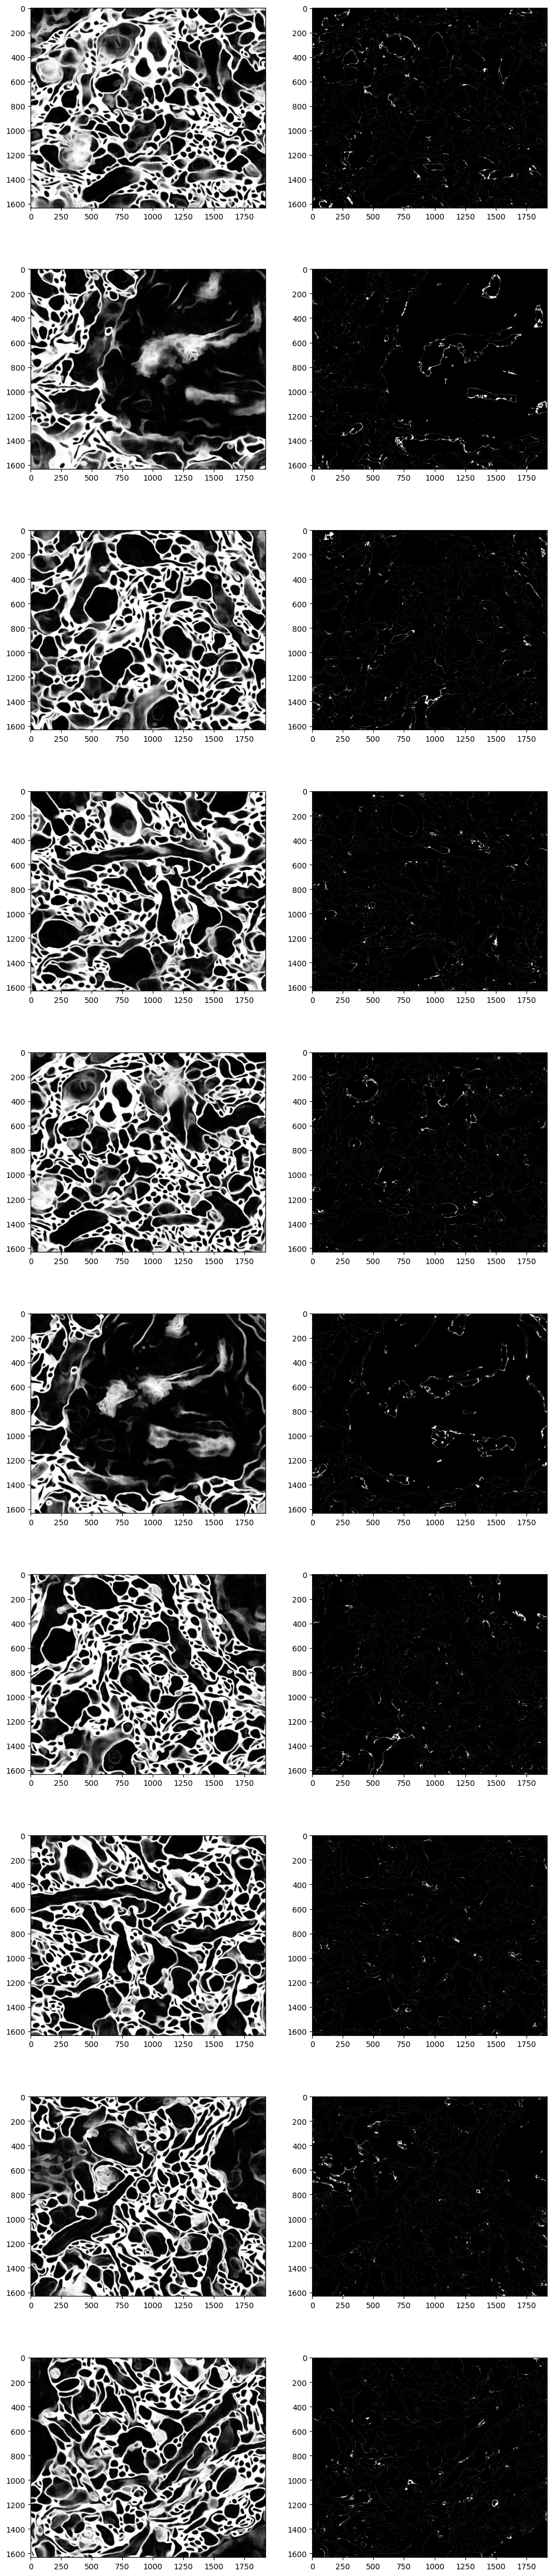

In [16]:
# plot first 10 membrane predictions and uncertainty masks
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(10, 2, figsize=(2*6, 60))
for i in range(10):
    axs[i, 0].imshow(mb_probs_list[i], cmap = 'gray')
    axs[i, 1].imshow(uncertainty_masks[i], cmap = 'gray')

In [2]:
import h5py
from tqdm import tqdm
data_path = "/storage2/projects/smartEM/errnet-data/smartem-data-error-em-test4.hdf5"
emaps = []
with h5py.File(data_path, "r") as f:
    for reg in tqdm(f.keys(), disable=True):
        group = f[reg]

        # print(group.keys())
        emaps.append(group["50"]["mask"][()])
        # emap = group["errmap"]
        # emap = emap[()]
        # emaps.append(emap)


  



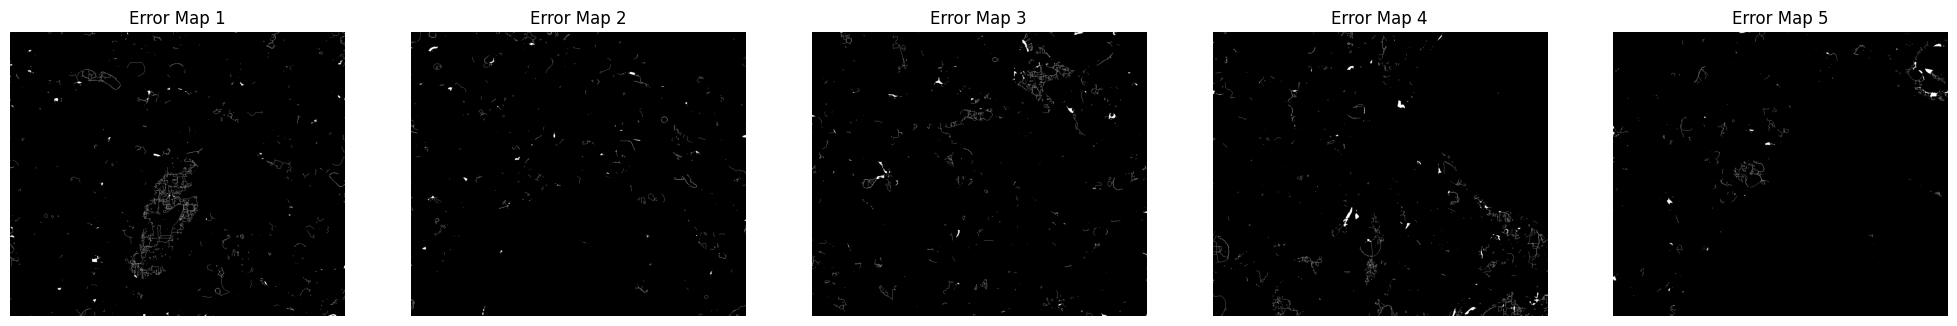

In [3]:
# plot emaps in subplot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

fig, axs = plt.subplots(1, len(emaps), figsize=(len(emaps)*5, 5))
for i, emap in enumerate(emaps):
    axs[i].imshow(emap, cmap="gray")
    axs[i].set_title(f"Error Map {i+1}")
    axs[i].axis("off")